<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled269GPU4def2svp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Structure: 4S39_active (4S38.cif) [fe4s4]
  Found BASE checkpoint /content/def2svp_checkpoints/4S39_active_base_def2svp.npz, loading.
  Found MODE-B checkpoint /content/def2svp_checkpoints/4S39_active_modeB_def2svp.npz, loading.

Structure: 4S3E_inhib7 (4S34S3A.cif) [fe4s4]
  Found BASE checkpoint /content/def2svp_checkpoints/4S3E_inhib7_base_def2svp.npz, loading.
  Found MODE-B checkpoint /content/def2svp_checkpoints/4S3E_inhib7_modeB_def2svp.npz, loading.

Saved figure to: /content/4S39_4S3E_def2svp_dteeth_curves.png


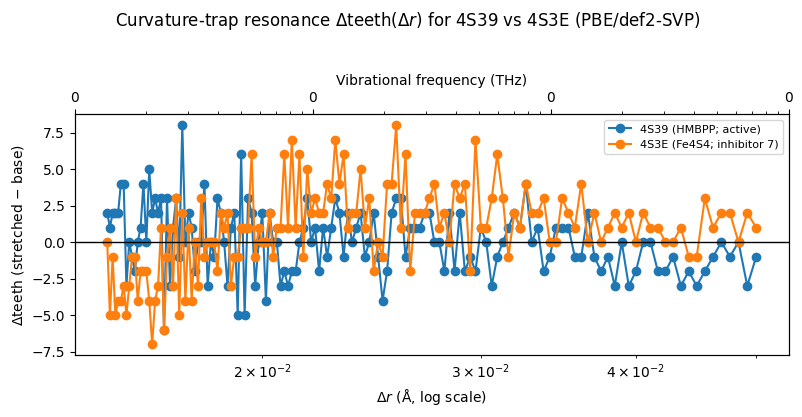

In [ ]:
# [ 1]  ============================================================
# [ 2]  Fe-S curvature-trap pipeline (4S39 & 4S3E, PBE/def2-SVP) — GPU hybrid (Option A)
# [ 3]  - Reads CIF from /content/structures
# [ 4]  - Extracts Fe4S4 clusters
# [ 5]  - Runs SCF (with optional GPU via GPU4PySCF, Newton fallback)
# [ 6]  - Computes |∇²ρ| on 32^3 grid (CPU)
# [ 7]  - Builds dense Δteeth(Δr) curves (Nbins = 60..200)
# [ 8]  - Plots 4S39 vs 4S3E (Fig-8 style)
# [ 9]  - Saves checkpoints: laplacian + atoms as .npz
# [10]  ============================================================

# [11]  Install deps (Colab)
!pip install -q gemmi pyscf  # core deps

# [11a] OPTIONAL: Uncomment ONE of these if you know your CUDA version and want GPU4PySCF
#        (Colab these days is usually CUDA 12.x)
# !pip install -q gpu4pyscf-cuda11x cutensor-cu11   # [11a] CUDA 11.x
# !pip install -q gpu4pyscf-cuda12x cutensor-cu12   # [11b] CUDA 12.x

# [12]  Imports
import numpy as np                    # [13]
import matplotlib.pyplot as plt       # [14]
from pathlib import Path              # [15]
import gemmi                          # [16]
from pyscf import gto, dft            # [17]

# [18]  Paths
STRUCT_DIR = Path("/content/structures")                    # [19]
CKPT_DIR   = Path("/content/def2svp_checkpoints")           # [20]
CKPT_DIR.mkdir(parents=True, exist_ok=True)                 # [21]

# [22]  Structures: label, file, type
STRUCTS = [
    ("4S39_active", "4S38.cif", "fe4s4"),   # [23]
    ("4S3E_inhib7", "4S34S3A.cif", "fe4s4"),   # [24]
]

# [25]  Curvature grid
L_BOX  = 3.0      # Å half-length of cube         # [26]
N_GRID = 32       # 32^3 ~ 32768 grid points      # [27]

# [28]  Mode B amplitude
MODE_B_SHIFT = 0.20    # Å                        # [29]

# [30]  Δr sampling: Nbins 60..200 (dense, Fig-8-like)
NBINS_LIST = list(range(60, 201))                # [31]
L_EFF      = 3.0   # Å (for Δr = L_EFF / Nbins)  # [32]

# [33]  ---------- Helpers ----------

def read_structure_any(path: Path):
    """Read CIF/PDB via gemmi."""
    print(f"  Reading structure from {path}")    # [34]
    st = gemmi.read_structure(str(path))         # [35]
    return st                                     # [36]

def get_fe_s_clusters(struct, cutoff=3.0):
    """Return list of connectivity clusters of Fe/S atoms."""
    atoms = []                                   # [37]
    for model in struct:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    el = atom.element.name.upper()
                    if el in ("FE", "S"):
                        atoms.append(atom)
    if not atoms:
        raise RuntimeError("No Fe or S atoms found")   # [38]

    # Explicitly unpack gemmi.Position → (x,y,z)
    coords = np.array(
        [[float(a.pos.x), float(a.pos.y), float(a.pos.z)] for a in atoms],
        dtype=float,
    )                                            # [39]

    n = len(atoms)                               # [40]
    adj = [[] for _ in range(n)]                # [41]
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(coords[i] - coords[j])
            if d <= cutoff:
                adj[i].append(j)
                adj[j].append(i)

    clusters = []                                # [42]
    visited = [False]*n                          # [43]
    for i in range(n):
        if visited[i]:
            continue
        stack = [i]
        comp  = []
        visited[i] = True
        while stack:
            k = stack.pop()
            comp.append(atoms[k])
            for nb in adj[k]:
                if not visited[nb]:
                    visited[nb] = True
                    stack.append(nb)
        clusters.append(comp)
    print(f"  Found {len(clusters)} Fe/S connectivity clusters")
    return clusters                              # [44]

def select_cluster(clusters, kind="fe4s4"):
    """Pick Fe4S4 (or Fe3S4) cluster closest to global Fe/S centroid."""
    desired_fe = 4 if kind.lower() == "fe4s4" else 3   # [45]
    desired_s  = 4                                     # [46]

    candidates = []
    for comp in clusters:
        n_fe = sum(1 for a in comp if a.element.name.upper() == "FE")
        n_s  = sum(1 for a in comp if a.element.name.upper() == "S")
        if n_fe == desired_fe and n_s >= desired_s:
            candidates.append(comp)
    if not candidates:
        raise RuntimeError(f"No {kind} cluster found") # [47]

    all_atoms  = [a for c in candidates for a in c]
    all_coords = np.array(
        [[a.pos.x, a.pos.y, a.pos.z] for a in all_atoms],
        dtype=float,
    )
    global_cent = all_coords.mean(axis=0)              # [48]

    def centroid(comp):
        coords = np.array(
            [[a.pos.x, a.pos.y, a.pos.z] for a in comp],
            dtype=float,
        )
        return coords.mean(axis=0)

    best, best_d = None, 1e9
    for comp in candidates:
        c = centroid(comp)
        d = np.linalg.norm(c - global_cent)
        if d < best_d:
            best, best_d = comp, d
    print(f"  Selected {kind} cluster with {len(best)} atoms")
    return best                                       # [49]

def atoms_to_pyscf(cluster_atoms):
    """Convert gemmi atoms → PySCF atom list centered at origin."""
    coords = np.array(
        [[float(a.pos.x), float(a.pos.y), float(a.pos.z)] for a in cluster_atoms],
        dtype=float,
    )
    centre = coords.mean(axis=0)
    coords -= centre
    pys_atoms = []
    for atom, pos in zip(cluster_atoms, coords):
        sym = atom.element.name.capitalize()
        pys_atoms.append((sym, (float(pos[0]), float(pos[1]), float(pos[2]))))
    return pys_atoms                                 # [50]

def apply_mode_b(pys_atoms, shift=0.20):
    """Asymmetric Fe–S stretch: move closest S for first 2 Fe centres."""
    symbols = [a[0] for a in pys_atoms]
    coords  = np.array([a[1] for a in pys_atoms], float)
    fe_idx  = [i for i,s in enumerate(symbols) if s.lower()=="fe"]
    s_idx   = [i for i,s in enumerate(symbols) if s.lower()=="s"]
    if len(fe_idx) < 2 or len(s_idx) < 2:
        raise RuntimeError("Need at least 2 Fe and 2 S for Mode B")

    new_coords = coords.copy()
    sign = +1.0
    for fi in fe_idx[:2]:
        fe_pos = coords[fi]
        best_j, best_d = None, 1e9
        for sj in s_idx:
            d = np.linalg.norm(coords[sj] - fe_pos)
            if d < best_d:
                best_j, best_d = sj, d
        if best_j is None:
            continue
        vec  = coords[best_j] - fe_pos
        norm = np.linalg.norm(vec)
        if norm < 1e-6:
            continue
        u = vec / norm
        new_coords[best_j] += sign * shift * u
        sign *= -1.0

    new_atoms = []
    for sym, pos in zip(symbols, new_coords):
        new_atoms.append((sym, (float(pos[0]), float(pos[1]), float(pos[2]))))
    return new_atoms                                  # [51]

def run_scf_with_newton(mol_atoms, basis="def2-svp", charge=0, spin=0):
    """
    RKS PBE with DIIS then Newton fallback.
    Hybrid GPU (Option A): try GPU4PySCF via .to_gpu(), then bring mf back to CPU.
    """
    mol = gto.Mole()                                  # [52]
    mol.build(atom=mol_atoms, basis=basis,
              charge=charge, spin=spin, verbose=4)    # [53]

    mf = dft.RKS(mol)                                 # [54]
    mf.xc = "PBE"                                     # [55]
    mf.conv_tol = 1e-6                                # [56]

    use_gpu = False                                   # [57]
    # Try to move the SCF object to GPU4PySCF if available
    try:
        mf = mf.to_gpu()                              # [58]
        use_gpu = True                                # [59]
        print("    SCF: using GPU4PySCF backend")     # [60]
    except Exception as e:
        print(f"    SCF: GPU not available, staying on CPU ({e})")  # [61]

    print("    SCF: starting DIIS...")                # [62]
    e = mf.kernel()                                   # [63]

    # If converged after DIIS
    if getattr(mf, "converged", False):               # [64]
        print(f"    DIIS converged: E = {e:.6f} Ha")  # [65]
        if use_gpu:
            # Bring SCF object back to CPU so downstream code sees a standard PySCF mf
            mf = mf.to_cpu()                          # [66]
            print("    SCF: moved object back to CPU")# [67]
        return mol, mf                                # [68]

    # If DIIS failed, try Newton (on same backend: GPU or CPU)
    print("    DIIS failed, trying Newton solver...") # [69]
    try:
        mf_new = mf.newton()                          # [70]
        e2 = mf_new.kernel()                          # [71]
        if getattr(mf_new, "converged", False):       # [72]
            print(f"    Newton converged: E = {e2:.6f} Ha")  # [73]
            if use_gpu:
                mf_new = mf_new.to_cpu()              # [74]
                print("    SCF: moved Newton object back to CPU")  # [75]
            return mol, mf_new                        # [76]
    except Exception as e_nt:
        print(f"    Newton solver failed: {e_nt}")    # [77]

    raise RuntimeError("SCF did not converge (DIIS + Newton)")   # [78]

def compute_abs_laplacian(mol, mf, L=L_BOX, N=N_GRID):
    """Compute |∇²ρ| on cubic grid of side 2L (Å) (CPU finite differences)."""
    xs = np.linspace(-L, L, N)
    ys = np.linspace(-L, L, N)
    zs = np.linspace(-L, L, N)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    print("    Evaluating AO and density on grid...")
    ao = dft.numint.eval_ao(mol, coords)
    dm = mf.make_rdm1()
    rho = dft.numint.eval_rho(mol, ao, dm)
    rho_grid = rho.reshape(N, N, N)

    dx = xs[1] - xs[0]
    dy = ys[1] - ys[0]
    dz = zs[1] - zs[0]

    print("    Computing finite-difference Laplacian...")
    d2x = (np.roll(rho_grid, -1, 0) - 2*rho_grid + np.roll(rho_grid, 1, 0)) / (dx**2)
    d2y = (np.roll(rho_grid, -1, 1) - 2*rho_grid + np.roll(rho_grid, 1, 1)) / (dy**2)
    d2z = (np.roll(rho_grid, -1, 2) - 2*rho_grid + np.roll(rho_grid, 1, 2)) / (dz**2)

    lap   = d2x + d2y + d2z
    kappa = np.abs(lap.ravel())
    return kappa                                     # [79]

def count_traps(kappa, nbins=120, pdf_thresh=1e-9):
    """Return (trap_count, pdf, edges) for curvature comb."""
    k_clip = np.clip(kappa, None, np.percentile(kappa, 99.5))
    hist, edges = np.histogram(k_clip, bins=nbins, density=True)
    pdf = hist
    below  = pdf < pdf_thresh
    n_trap = 0
    in_trap = False
    for flag in below:
        if flag and not in_trap:
            in_trap = True
            n_trap += 1
        elif not flag and in_trap:
            in_trap = False
    return n_trap, pdf, edges                        # [80]

def delta_r_to_thz(delta_r):
    """Δr (Å) → THz (harmonic mapping, qualitative)."""
    hbar = 1.054571817e-34
    m_fe = 55.845 * 1.66053906660e-27
    m_s  = 32.06  * 1.66053906660e-27
    m_red = (m_fe * m_s) / (m_fe + m_s)
    A_m = delta_r * 1e-10
    eps = 1e-20
    nu_hz = hbar / (2.0 * m_red * (A_m**2 + eps))
    return nu_hz / 1e12                               # [81]

# [82]  ---------- Main: SCF + Laplacian + Δteeth(Δr) ----------

results = {}                                          # [83]

for label, fname, kind in STRUCTS:
    print("\n========================================")
    print(f"Structure: {label} ({fname}) [{kind}]")

    base_npz = CKPT_DIR / f"{label}_base_def2svp.npz"
    dist_npz = CKPT_DIR / f"{label}_modeB_def2svp.npz"

    # --- Load or build base laplacian ---
    if base_npz.exists():
        print(f"  Found BASE checkpoint {base_npz}, loading.")
        kappa_base = np.load(base_npz)["laplacian"]
        pys_atoms_base = np.load(base_npz, allow_pickle=True)["atoms"]
    else:
        st = read_structure_any(STRUCT_DIR / fname)
        clusters = get_fe_s_clusters(st, cutoff=3.0)
        core = select_cluster(clusters, kind=kind)
        pys_atoms_base = atoms_to_pyscf(core)
        print("  Running SCF for BASE geometry...")
        mol_b, mf_b = run_scf_with_newton(pys_atoms_base, basis="def2-svp")
        print("  Computing Laplacian for BASE geometry...")
        kappa_base = compute_abs_laplacian(mol_b, mf_b, L=L_BOX, N=N_GRID)
        print(f"  Saving BASE checkpoint → {base_npz}")
        np.savez_compressed(
            base_npz,
            laplacian=kappa_base,
            atoms=np.array(pys_atoms_base, dtype=object),
            label=label,
            state="base",
        )

    # --- Load or build distorted laplacian ---
    if dist_npz.exists():
        print(f"  Found MODE-B checkpoint {dist_npz}, loading.")
        kappa_dist = np.load(dist_npz)["laplacian"]
    else:
        if isinstance(pys_atoms_base, np.ndarray):  # from checkpoint
            pys_atoms_base_list = list(pys_atoms_base)
        else:
            pys_atoms_base_list = pys_atoms_base
        pys_atoms_dist = apply_mode_b(pys_atoms_base_list, shift=MODE_B_SHIFT)
        print("  Running SCF for MODE-B geometry...")
        mol_d, mf_d = run_scf_with_newton(pys_atoms_dist, basis="def2-svp")
        print("  Computing Laplacian for MODE-B geometry...")
        kappa_dist = compute_abs_laplacian(mol_d, mf_d, L=L_BOX, N=N_GRID)
        print(f"  Saving MODE-B checkpoint → {dist_npz}")
        np.savez_compressed(
            dist_npz,
            laplacian=kappa_dist,
            atoms=np.array(pys_atoms_dist, dtype=object),
            label=label,
            state="modeB",
        )

    # --- Build Δteeth(Δr) for this structure ---
    delta_r_list     = []
    delta_teeth_list = []

    for nb in NBINS_LIST:
        n_base, _, _ = count_traps(kappa_base, nbins=nb)
        n_dist, _, _ = count_traps(kappa_dist, nbins=nb)
        dteeth = n_dist - n_base
        dr = L_EFF / nb
        delta_r_list.append(dr)
        delta_teeth_list.append(dteeth)

    results[label] = (np.array(delta_r_list), np.array(delta_teeth_list))

# [84]  ---------- Plot 4S39 vs 4S3E (Fig-8 style) ----------

fig, ax_bottom = plt.subplots(figsize=(8,4))

label_map = {
    "4S39_active": "4S39 (HMBPP; active)",
    "4S3E_inhib7": "4S3E (Fe4S4; inhibitor 7)",
}

for key, (dr_arr, dteeth_arr) in results.items():
    ax_bottom.plot(dr_arr, dteeth_arr, marker="o", label=label_map.get(key, key))

ax_bottom.set_xscale("log")
ax_bottom.axhline(0.0, linewidth=1, color="black")
ax_bottom.set_xlabel(r"$\Delta r$ (Å, log scale)")
ax_bottom.set_ylabel(r"$\Delta \mathrm{teeth}$ (stretched $-$ base)")

# Twin THz axis
ax_top = ax_bottom.twiny()
ax_top.set_xscale("log")
ax_top.set_xlim(ax_bottom.get_xlim())
ax_top.set_xlabel("Vibrational frequency (THz)")

dr_ticks = ax_bottom.get_xticks()
dr_ticks = dr_ticks[dr_ticks > 0]
ax_top.set_xticks(dr_ticks)
thz_labels = [f"{delta_r_to_thz(float(dr)):.0f}" for dr in dr_ticks]
ax_top.set_xticklabels(thz_labels)

ax_bottom.legend(fontsize=8, loc="best")
fig.suptitle(r"Curvature-trap resonance $\Delta\mathrm{teeth}(\Delta r)$ "
             r"for 4S39 vs 4S3E (PBE/def2-SVP)",
             y=1.03)

plt.tight_layout()
out_png = "/content/4S39_4S3E_def2svp_dteeth_curves.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print("\nSaved figure to:", out_png)
plt.show()

In [ ]:
import shutil
from pathlib import Path

# --- Set source and destination paths ---
src_dir = Path("/content")               # folder containing your CIFs
dst_dir = Path("/content/structures")    # target folder

# --- Create destination folder if needed ---
dst_dir.mkdir(parents=True, exist_ok=True)

# --- Move all .cif files ---
cif_files = list(src_dir.glob("*.cif"))
print(f"Found {len(cif_files)} CIF files in {src_dir}")

for f in cif_files:
    dest = dst_dir / f.name
    print(f"Moving {f} → {dest}")
    shutil.move(str(f), str(dest))

print("Done.")

Found 0 CIF files in /content
Done.
